# Feature Computation & Verification

This notebook allows for step-by-step execution of feature engineering pipelines, ensuring data integrity and allowing for visual verification at each stage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path('../').resolve()
sys.path.append(str(project_root))

from features.trend_indicator_pipeline_pkg import (
    TrendIndicatorPipeline,
    MomentumIndicatorPipeline,
    VolatilityIndicatorPipeline,
    FractalDimensionPipeline,
    TimeSeriesFeaturesPipeline
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Data

In [2]:
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m.csv'
print(f"Loading data from {data_path}...")
df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

print(f"Data Shape: {df.shape}")
print(df.head())

Loading data from /Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTCUSDT_2021_2023_1m.csv...
Data Shape: (1534847, 5)
                         Open      High       Low     Close     Volume
timestamp                                                             
2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66  27.457032
2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91  58.477501
2021-01-01 00:02:00  29009.54  29016.71  28973.58  28989.30  42.470329
2021-01-01 00:03:00  28989.68  28999.85  28972.33  28982.69  30.360677
2021-01-01 00:04:00  28982.67  28995.93  28971.80  28975.65  24.124339


## 2. Trend Indicators

Running Trend Indicators...
[INFO] Written trend indicators for BTCUSDT to ArcticDB


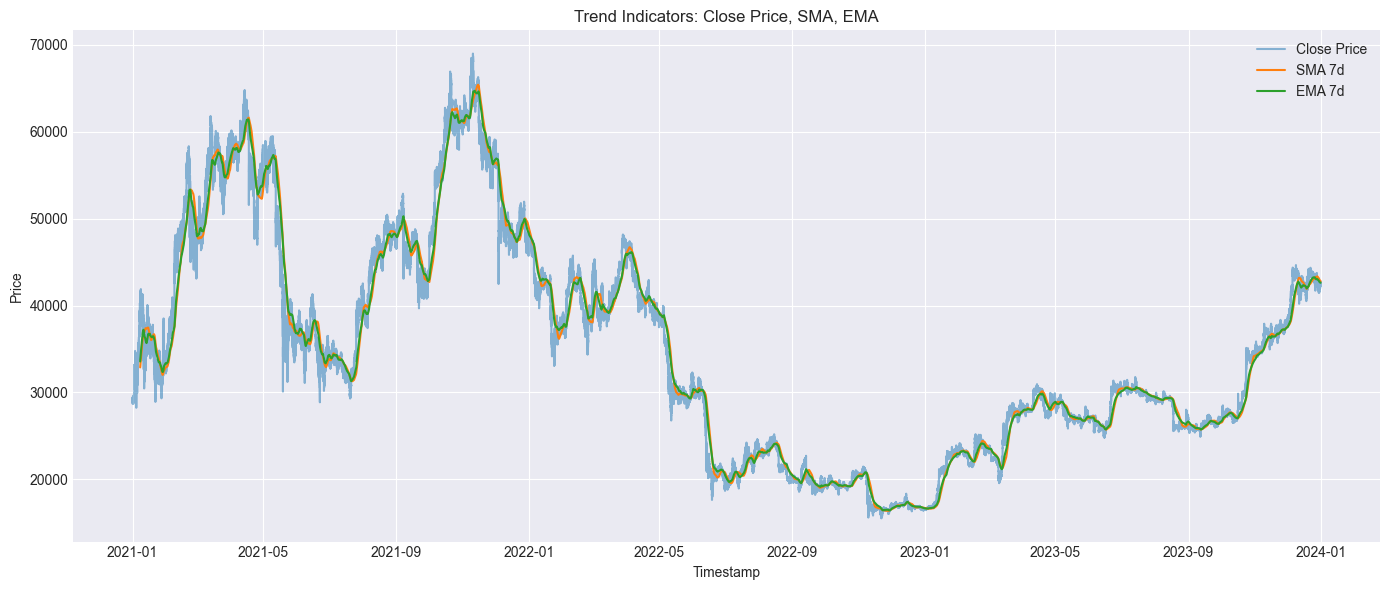

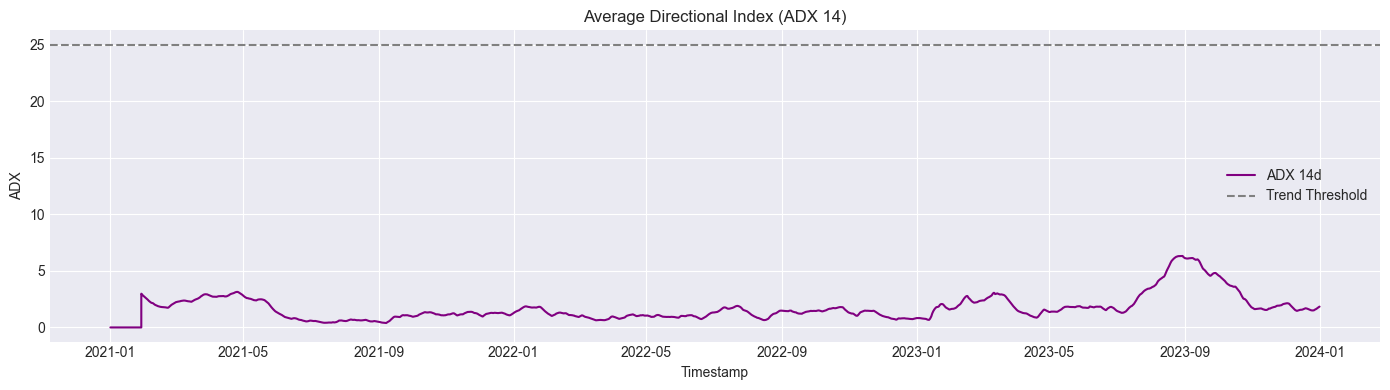


Trend Indicators Added:
Index(['sma_7d', 'sma_30d', 'sma_90d', 'ema_7d', 'ema_21d', 'adx_14d'], dtype='object')
                       Close        sma_7d        ema_7d   adx_14d
timestamp                                                         
2023-12-31 14:23:00  42429.2  42798.223313  42621.028587  1.841082
2023-12-31 14:24:00  42428.5  42798.109425  42620.990391  1.841131
2023-12-31 14:25:00  42422.6  42797.995198  42620.951031  1.841180
2023-12-31 14:26:00  42433.2  42797.881627  42620.913783  1.841229
2023-12-31 14:27:00  42447.6  42797.768373  42620.879399  1.841278


In [3]:
print("Running Trend Indicators...")
trend_pipe = TrendIndicatorPipeline()
df = trend_pipe.run(df, symbol="BTCUSDT", sma_windows=[7, 30, 90], ema_spans=[7, 21], adx_windows=[14])

print("\nTrend Indicators Added:")
print(df.columns[df.columns.str.contains('sma|ema|adx')])
print(df.iloc[-5:][['Close', 'sma_7d', 'ema_7d', 'adx_14d']])

## 3. Momentum Indicators (with Optimized Dynamic RSI)

In [ ]:
print("Running Momentum Indicators (this includes Numba-optimized Dynamic RSI)...")
mom_pipe = MomentumIndicatorPipeline()
# Note: Dynamic RSI calculation for 30-day window on 1.5M rows might still take a minute or two
df = mom_pipe.run(df, symbol="BTCUSDT", rsi_windows=[14, 30], stoch_windows=[14], macd_params=(12, 26, 9))

print("\nMomentum Indicators Added:")
print(df.columns[df.columns.str.contains('rsi|stoch|macd')])

# Check Dynamic RSI Regimes
if 'rsi_14d_regime' in df.columns:
    print("\nDynamic RSI Regime Distribution:")
    print(df['rsi_14d_regime'].value_counts())

Running Momentum Indicators (this includes Numba-optimized Dynamic RSI)...


20251122 03:27:09.718182 18163184 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/Crypto_Research/arctic_store/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[15655]


[INFO] Calculating Dynamic RSI thresholds (Window: 43200)...


## 4. Volatility Indicators

In [ ]:
print("Running Volatility Indicators...")
vol_pipe = VolatilityIndicatorPipeline()
df = vol_pipe.run(df, symbol="BTCUSDT", bb_days_list=[20], atr_days_list=[14])

print("\nVolatility Indicators Added:")
print(df.columns[df.columns.str.contains('bb_|atr')])

## 5. Time-Series Features

In [ ]:
print("Running Time-Series Features...")
ts_pipe = TimeSeriesFeaturesPipeline()
df = ts_pipe.run(df, symbol="BTCUSDT", trend_days=[1, 7, 30], vol_days=[7, 30])

print("\nTime-Series Features Added:")
print(df.columns[df.columns.str.contains('trend_|residual_|volatility_')])

## 6. Fractal Dimension (Parallelized)

In [ ]:
print("Running Fractal Dimension (Parallelized)...")
fd_pipe = FractalDimensionPipeline(max_workers=4)
# Using parallel processing
df = fd_pipe.run(df, symbol="BTCUSDT", days_list=[7], use_parallel=True)

print("\nFractal Dimension Added:")
print(df.columns[df.columns.str.contains('fd_')])

## 7. Save Final Dataset

In [ ]:
output_file = project_root / 'data' / 'BTCUSDT_2021_2023_1m_features.csv'
print(f"Saving feature-rich dataset to {output_file}...")
df.to_csv(output_file)
print("Done!")